In [14]:
# Below modules require "pip install transformers[torch]" in the terminal

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "bert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 350
BATCH_SIZE = 16
EPOCHS = 10

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
### Divide data into train, validation and test 
import pandas as pd
import numpy as np
data = pd.read_csv('data/uniform_distribution.csv')
data['cat_rating'] = data['cat_rating'].apply(pd.to_numeric)

#split data... .7 means 70% train and the .85 means 2x 15% for the validate and test
train, validate, test = np.split(data.sample(frac=1), [int(.7*len(data)), int(.85*len(data))])
train["joke"] = train["joke"].astype(str)
train["cat_rating"] = train["cat_rating"].astype(float) # was float with no quotation marks

validate["joke"] = validate["joke"].astype(str)
validate["cat_rating"] = validate["cat_rating"].astype(float)

test["joke"] = test["joke"].astype(str)
test["cat_rating"] = test["cat_rating"].astype(float)

/work/priv/venvs/nlp-e23/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [16]:
from math import isnan

def df_to_list_of_dicts(data):
    list_of_dicts = []
    for i,idx in enumerate(data.index):
        dic = {'id' : idx, 'text' : data["joke"][idx], 'score' : data["cat_rating"][idx]}
        if not isnan(dic['score']):
            list_of_dicts.append(dic)
    return list_of_dicts

In [17]:
import json
train1 = df_to_list_of_dicts(train)
with open("data/train.jsonlines", 'w') as f:
    for d in train1:
        json.dump(d, f)
        f.write('\n')

test1 = df_to_list_of_dicts(test)
with open("data/test.jsonlines", 'w') as f:
    for d in test1:
        json.dump(d, f)
        f.write('\n')

validate1 = df_to_list_of_dicts(validate)

with open("data/validate.jsonlines", 'w') as f:
    for d in validate1:
        json.dump(d, f)
        f.write('\n')


In [18]:

from datasets import Dataset
# if issues
raw_train_ds = Dataset.from_json("data/train.jsonlines")
raw_test_ds = Dataset.from_json("data/test.jsonlines")
raw_val_ds = Dataset.from_json("data/validate.jsonlines")

# This line prints the description of train_ds
raw_train_ds, raw_test_ds,raw_val_ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['id', 'text', 'score'],
     num_rows: 20924
 }),
 Dataset({
     features: ['id', 'text', 'score'],
     num_rows: 4487
 }),
 Dataset({
     features: ['id', 'text', 'score'],
     num_rows: 4483
 }))

In [19]:
ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=350)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id","text", "score"])


Map:   0%|          | 0/20924 [00:00<?, ? examples/s]

Map:   0%|          | 0/4483 [00:00<?, ? examples/s]

Map:   0%|          | 0/4487 [00:00<?, ? examples/s]

In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="models/bert-fine-tuned-regression-2",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [21]:
import torch

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [10]:

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Detected kernel version 5.4.256, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,33.610300,33.135666,33.135670,4.975916,-0.004718,0.047269
2,32.017800,33.040100,33.040100,4.964679,-0.001820,0.048161
3,25.142000,35.843742,35.843742,5.082771,-0.086831,0.045931
4,16.783500,41.685429,41.685429,5.357954,-0.263958,0.052174
5,11.574700,42.079067,42.079067,5.376893,-0.275894,0.054181
6,8.669700,44.994751,44.994751,5.522403,-0.364302,0.049944
7,6.754000,45.571804,45.571804,5.561397,-0.381799,0.049052
8,5.373100,45.832886,45.832886,5.569749,-0.389715,0.053512
9,4.478700,44.709496,44.709496,5.524681,-0.355652,0.048384
10,4.045100,44.755291,44.755291,5.526838,-0.357041,0.046600


TrainOutput(global_step=13080, training_loss=15.184996093376697, metrics={'train_runtime': 44784.4033, 'train_samples_per_second': 4.673, 'train_steps_per_second': 0.292, 'total_flos': 3.7637390202006e+16, 'train_loss': 15.184996093376697, 'epoch': 10.0})

# Evaluation on test set


In [11]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()

{'eval_loss': 42.20734405517578,
 'eval_mse': 42.20734405517578,
 'eval_mae': 5.333274841308594,
 'eval_r2': -0.26442046005759967,
 'eval_accuracy': 0.05375864376533571,
 'eval_runtime': 255.8269,
 'eval_samples_per_second': 17.524,
 'eval_steps_per_second': 1.098,
 'epoch': 10.0}

In [27]:
# check if we can load the saved model:

tuned_model = AutoModelForSequenceClassification.from_pretrained("models/bert-fine-tuned-regression-2/checkpoint-13080", num_labels=1)

trainer = RegressionTrainer(
    model=tuned_model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    test_dataset=ds["test_human"]
    compute_metrics=compute_metrics_for_regression,
)

Detected kernel version 5.4.228, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Evaluation on data from human raters

In [23]:
#load the csv logfiles and generate scores based on the comparisons
import pandas as pd
import os

logfilenames =  [f for f in os.listdir('logfiles')]


dataframes = []
for filename in logfilenames:
    df = pd.read_csv("logfiles/" + filename)
    dataframes.append(df)

human_data = pd.concat(dataframes)

human_data = human_data.astype({"joke_left" : "string", "joke_right": "string", "choice": "string"})

human_data["row_index"] = [i for i in range(len(human_data))]

human_data = human_data.set_index("row_index")


# This file contains the jokes and the joke IDs. We will use these for generating scores from the logfiles
new_jokes = pd.read_csv("new_jokes.csv")


# Now, generate the scores

new_jokes["cat_rating"] = [0 for i in range(len(new_jokes["joke"]))] # we call it cat_rating again, so it works with the previous code

for i in range(len(human_data)):
    if human_data["choice"][i] == "L":
        winner = human_data["joke_left"][i]
    else:
        winner = human_data["joke_right"][i]
    new_jokes.loc[new_jokes["joke_id"] == winner, "cat_rating"] += 1

new_jokes = new_jokes.astype({"cat_rating" : "float"})


In [25]:
# Turn the data into something our fine-tuned BERT can take as input and evaluate

test_human1 = df_to_list_of_dicts(new_jokes)
with open("data/test_human.jsonlines", 'w') as f:
    for d in test_human1:
        json.dump(d, f)
        f.write('\n')

raw_test_human_ds = Dataset.from_json("data/test_human.jsonlines")

ds["test_human"] = raw_test_human_ds

ds["test_human"] = ds["test_human"].map(preprocess_function, remove_columns=["id","text", "score"])


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [33]:
# Evaluate and create model predictions
#trainer.eval_dataset=ds["test_human"]
predictions = trainer.predict(ds["test_human"])

#print(predictions)


PredictionOutput(predictions=array([[13.684747 ],
       [ 3.2426322],
       [16.493856 ],
       [15.447756 ],
       [17.774357 ],
       [ 9.248093 ],
       [ 7.7793045],
       [16.505943 ],
       [18.154163 ],
       [17.515574 ],
       [18.089407 ],
       [14.337882 ],
       [11.832642 ],
       [ 4.474116 ],
       [ 9.788297 ],
       [ 4.3581734],
       [ 5.4911184],
       [ 6.3354754],
       [12.832766 ],
       [ 9.800655 ],
       [ 4.6608477],
       [ 6.6413302],
       [ 3.6570697],
       [15.219198 ],
       [14.2778425],
       [11.096803 ],
       [ 9.535492 ],
       [14.07819  ],
       [17.905807 ],
       [15.565894 ]], dtype=float32), label_ids=array([ 7.,  6.,  8., 12., 11.,  5., 11., 11.,  6., 10., 14.,  8.,  8.,
        5.,  3.,  8.,  8., 10., 13.,  6., 12., 11., 10., 11., 11., 12.,
        7.,  7., 10.,  9.], dtype=float32), metrics={'test_loss': 30.50503921508789, 'test_mse': 30.505035400390625, 'test_mae': 4.889538764953613, 'test_r2': -3.39976506

In [50]:
#np.save("predictions.txt", predictions)

# Print the metrics computed by predict()
print(predictions[2])

{'test_loss': 30.50503921508789, 'test_mse': 30.505035400390625, 'test_mae': 4.889538764953613, 'test_r2': -3.3997650690412575, 'test_accuracy': 0.03333333333333333, 'test_runtime': 18.7947, 'test_samples_per_second': 1.596, 'test_steps_per_second': 0.106}


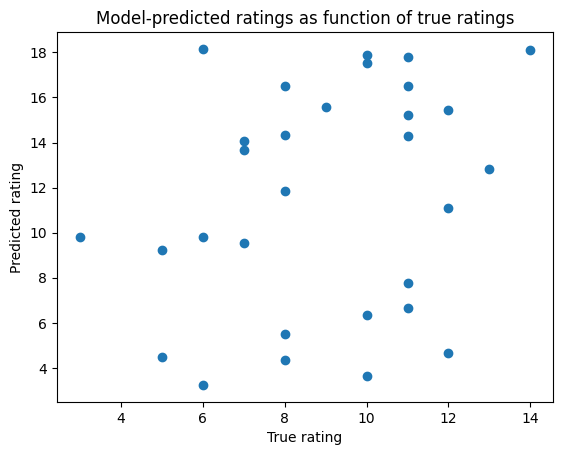

In [46]:
# Visualize the predicted ratings as function of true ratings
import matplotlib.pyplot as plt

plt.figure()
plt.plot(predictions[1], predictions[0], "o")
plt.xlabel("True rating")
plt.ylabel("Predicted rating")
plt.title("Model-predicted ratings as function of true ratings")
plt.show()